In [1]:
import numpy as np
import matplotlib.pyplot as plt
import natsort, glob, h5py
from scipy.optimize import curve_fit
import scipy.signal

In [2]:
#path = r"C:/Data/20220630/LXe_Full_E_field_-2kV_source_reposition_Gain_source_removed/"
path = '/gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/'
SRS_gain = 100 # gain on the SRS bandpass filter
peak_threshold = 700 # upper bound of pedestal
breakdown = 27.4 # breakdown voltage of the SiPM
pedestal = 275 # center of noise pedestal peak

file_list = natsort.realsorted(glob.glob(path + "mca_*.h5"))[::-1]
print("Found %d files"%len(file_list))

Found 10 files


In [3]:
def gauss_fun(x, A, mu, sig):
    return A * np.exp( -(x-mu)**2/(2*sig**2) )

def lin_fun(x, m, x1):
    return m*(x-x1)

def lin_fun_const(x, m):
    return lin_fun(x,m,0)

In [4]:
def rebin_histogram(bins, counts, new_bin_size):
    """Rebin a histogram to a new bin size.
    Parameters:
        bins (np.ndarray): The bin edges of the histogram.
        counts (np.ndarray): The number of counts in each bin.
        new_bin_size (float): The size of the new bins.
    Returns:
        np.ndarray: The new bin edges.
        np.ndarray: The new bin counts.
    """
    # Find the new number of bins
    new_nbins = int((bins[-1] - bins[0]) / new_bin_size)
    # Create the new bin edges
    new_bins = np.linspace(bins[0], bins[-1], new_nbins + 1)
    # Digitize the original bins into the new bins
    digitized_bins = np.digitize(bins, new_bins)
    # Calculate the new counts
    new_counts = np.array([counts[digitized_bins == i].sum() for i in range(1, new_nbins + 1)])

    new_centers = new_bins[:-1] + np.diff(new_bins)/2
    return new_centers, new_counts

In [10]:
def find_peaks_and_fit(x_data, y_data, min_distance=20, max_peaks=5, min_thresh=10, binsize=50):
    # rebin data to make the histogram bins less small
    x, y = rebin_histogram(x_data, y_data, binsize)
    
    # Find the peaks in the spectrum using the find_peaks function from scipy.signal
    peaks_index, _ = scipy.signal.find_peaks(y, distance=min_distance)

    # Fit each peak with a Gaussian function using the curve_fit function from scipy
    peak_params = []
    peak_number = 1 # corresponds to single photoelectron
    for peak in peaks_index:
        if peak_number > max_peaks: # stopping the loop after we have reached the max number of peaks
            break
#         print(peak)
        if peak < min_thresh:
            continue

        # Initial guess for the Gaussian parameters
        amplitude_guess = y[peak]
        mean_guess = x[peak]
        standard_deviation_guess = 0.1 
        initial_guess = [amplitude_guess, mean_guess, standard_deviation_guess]

        # Perform the curve fitting
        try:
            params, params_covariance = curve_fit(gauss_fun, x, y, p0=initial_guess)
        except RuntimeError as r:
            peak_params.append([peak, np.nan, np.nan])
            xx = np.linspace( x[peak] - 2*standard_deviation_guess, x[peak] + 2*standard_deviation_guess, 100 )
            plt.plot( xx, gauss_fun(xx, *initial_guess), 'b' )
            continue
        peak_params.append([peak_number, params[1], np.sqrt(params_covariance[1,1])])
        peak_number+=1 # (goes to n*spe until it reaches max_peak)
    
    # Plot the original spectrum and the fitted Gaussian peaks
        plt.plot(x[peak], y[peak], 'o', label='peaks')
#     plt.plot(x, y, 'o', label='Original spectrum')
    for params in peak_params:
        print(params)
        plt.plot(x, gauss_fun(x, *params), label='Fitted peak')
    #plt.legend()
    plt.show()
    return np.array(peak_params), x, y

Working on file #0: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_33.90OV_source_0.h5
Distance:  20
[1, 1628.2798165137615, inf]
[2, 3181.4082568807344, inf]
[3, 4634.334862385322, inf]
[4, 6237.564220183487, inf]
[5, 7690.4908256880735, inf]


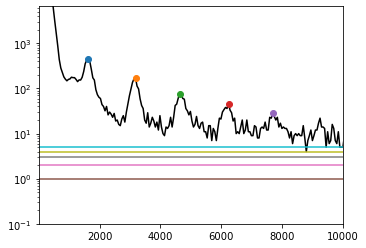

[[1.00000000e+00 1.62827982e+03            inf]
 [2.00000000e+00 3.18140826e+03            inf]
 [3.00000000e+00 4.63433486e+03            inf]
 [4.00000000e+00 6.23756422e+03            inf]
 [5.00000000e+00 7.69049083e+03            inf]]


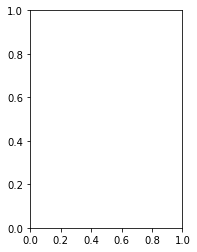

Working on file #1: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_33.40OV_source_0.h5
Distance:  20
[1, 1477.9770642201836, inf]
[2, 2930.903669724771, inf]
[3, 4333.729357798165, inf]
[4, 5736.55504587156, inf]
[5, 7239.58256880734, inf]


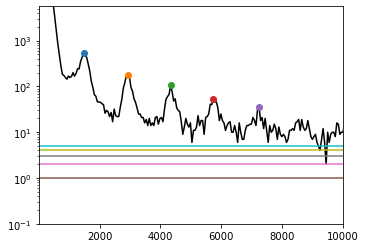

[[1.00000000e+00 1.47797706e+03            inf]
 [2.00000000e+00 2.93090367e+03            inf]
 [3.00000000e+00 4.33372936e+03            inf]
 [4.00000000e+00 5.73655505e+03            inf]
 [5.00000000e+00 7.23958257e+03            inf]]


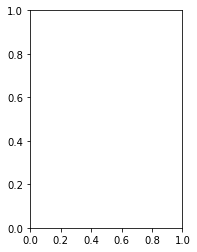

Working on file #2: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_32.90OV_source_0.h5
Distance:  20
[1, 1377.7752293577983, inf]
[2, 2680.3990825688074, inf]
[3, 3983.022935779817, inf]
[4, 5335.747706422018, inf]
[5, 6638.371559633028, inf]


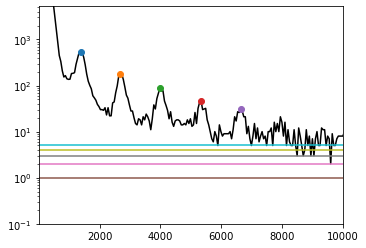

[[1.00000000e+00 1.37777523e+03            inf]
 [2.00000000e+00 2.68039908e+03            inf]
 [3.00000000e+00 3.98302294e+03            inf]
 [4.00000000e+00 5.33574771e+03            inf]
 [5.00000000e+00 6.63837156e+03            inf]]


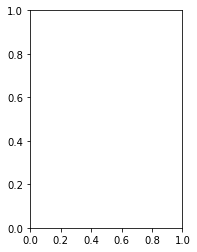

Working on file #3: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_32.40OV_source_0.h5
Distance:  20
[1, 1277.573394495413, inf]
[2, 2479.9954128440368, inf]
[3, 3682.417431192661, inf]
[4, 4884.839449541285, inf]
[5, 6037.160550458716, inf]


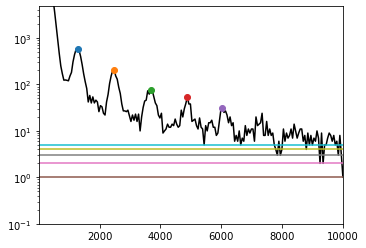

[[1.00000000e+00 1.27757339e+03            inf]
 [2.00000000e+00 2.47999541e+03            inf]
 [3.00000000e+00 3.68241743e+03            inf]
 [4.00000000e+00 4.88483945e+03            inf]
 [5.00000000e+00 6.03716055e+03            inf]]


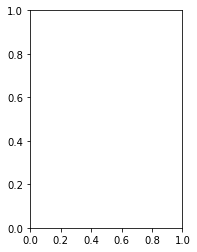

Working on file #4: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_31.90OV_source_0.h5
Distance:  15
[1, 1127.270642201835, inf]
[2, 2229.4908256880735, inf]
[3, 3331.711009174312, inf]
[4, 4333.729357798165, inf]
[5, 5385.848623853211, inf]


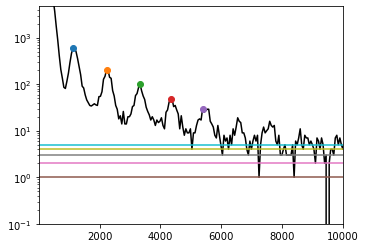

[[1.00000000e+00 1.12727064e+03            inf]
 [2.00000000e+00 2.22949083e+03            inf]
 [3.00000000e+00 3.33171101e+03            inf]
 [4.00000000e+00 4.33372936e+03            inf]
 [5.00000000e+00 5.38584862e+03            inf]]


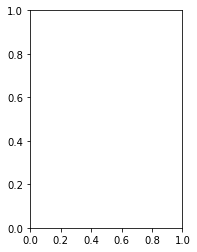

Working on file #5: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_31.40OV_source_0.h5
Distance:  15
[1, 1027.0688073394497, inf]
[2, 1978.9862385321103, inf]
[3, 2981.0045871559632, inf]
[4, 3932.922018348624, inf]
[5, 4985.04128440367, inf]


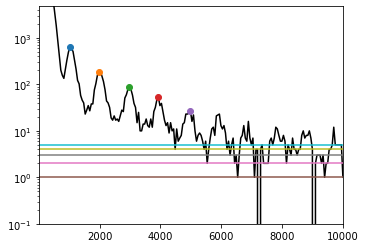

[[1.00000000e+00 1.02706881e+03            inf]
 [2.00000000e+00 1.97898624e+03            inf]
 [3.00000000e+00 2.98100459e+03            inf]
 [4.00000000e+00 3.93292202e+03            inf]
 [5.00000000e+00 4.98504128e+03            inf]]


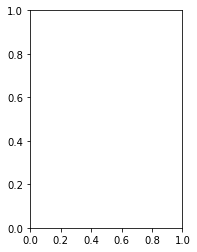

Working on file #6: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_30.90OV_source_0.h5
Distance:  15
[1, 926.8669724770643, inf]
[2, 1778.5825688073396, inf]
[3, 2630.298165137615, inf]
[4, 3482.0137614678897, inf]
[5, 4283.628440366972, inf]


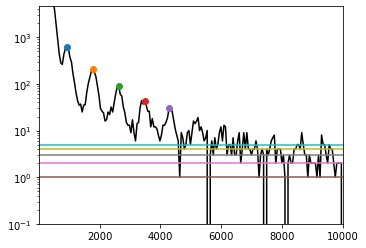

[[1.00000000e+00 9.26866972e+02            inf]
 [2.00000000e+00 1.77858257e+03            inf]
 [3.00000000e+00 2.63029817e+03            inf]
 [4.00000000e+00 3.48201376e+03            inf]
 [5.00000000e+00 4.28362844e+03            inf]]


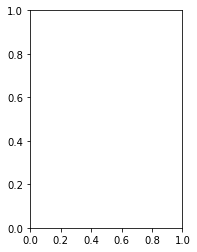

Working on file #7: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_30.40OV_source_0.h5
Distance:  10
[1, 776.5642201834862, inf]
[2, 1528.0779816513764, inf]
[3, 2229.4908256880735, inf]
[4, 2981.0045871559632, inf]
[5, 3732.5183486238534, inf]


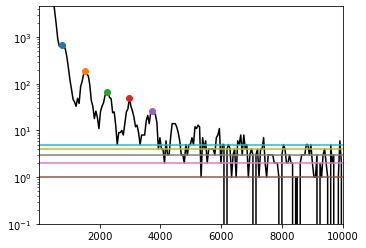

[[1.00000000e+00 7.76564220e+02            inf]
 [2.00000000e+00 1.52807798e+03            inf]
 [3.00000000e+00 2.22949083e+03            inf]
 [4.00000000e+00 2.98100459e+03            inf]
 [5.00000000e+00 3.73251835e+03            inf]]


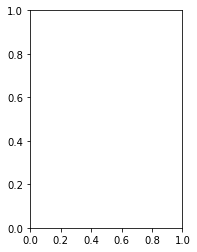

Working on file #8: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_29.90OV_source_0.h5
Distance:  10
[1, 1277.573394495413, inf]
[2, 1878.7844036697247, inf]
[3, 2479.9954128440368, inf]
[4, 3081.206422018349, inf]
[5, 3682.417431192661, inf]


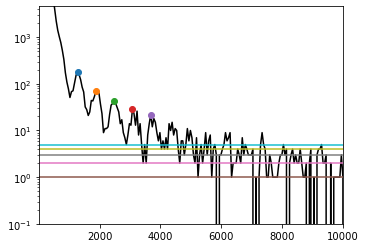

[[1.00000000e+00 1.27757339e+03            inf]
 [2.00000000e+00 1.87878440e+03            inf]
 [3.00000000e+00 2.47999541e+03            inf]
 [4.00000000e+00 3.08120642e+03            inf]
 [5.00000000e+00 3.68241743e+03            inf]]


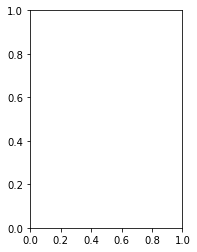

Working on file #9: /gpfs/gibbs/project/david_moore/mpw46/purity_monitor/20230213/step5/mca_keith_29.40OV_source_0.h5
Distance:  5
[1, 1077.1697247706422, inf]
[2, 1528.0779816513764, inf]
[3, 2029.0871559633028, inf]
[4, 2479.9954128440368, inf]
[5, 3031.1055045871562, inf]


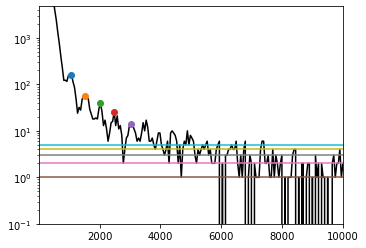

[[1.00000000e+00 1.07716972e+03            inf]
 [2.00000000e+00 1.52807798e+03            inf]
 [3.00000000e+00 2.02908716e+03            inf]
 [4.00000000e+00 2.47999541e+03            inf]
 [5.00000000e+00 3.03110550e+03            inf]]


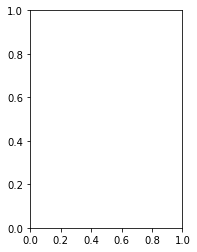

In [11]:
guess_1pe = 1100 * SRS_gain/100 - pedestal ## based on highest gain data
guess_sig = 0.1

distances = [20, 20, 20, 20, 15, 15, 15, 10, 10, 5]

gain_vs_volts = []
for i,(file, dist) in enumerate(zip(file_list, distances)): 
    print("Working on file #%d: %s"%(i,file))
    print('Distance: ', dist)

    file_parts = file.split("_")
#     print(file_parts)
    file_volts = float( file_parts[-3][:-2] ) # get voltage from filename
    try:
        file_wavelength = float(file_parts[-2]) # get wavelength from filename
    except ValueError:
        file_wavelength = file_parts[-2] # leaving tag as a string for source data



    f = h5py.File(file, 'r')  
    ch2 = f.get('ch2')
    for key in ch2.keys():
        mca_hist = np.array(ch2.get(key))
    bin_num = np.arange(len(mca_hist))
    b, c = rebin_histogram(bin_num, mca_hist, 50)
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.semilogy(b, c, 'k')
    plt.ylim(0.1, np.max(mca_hist)*2)
    plt.xlim(0.1, 10000)

    if(len(gain_vs_volts) > 0):
        guess_1pe = gain_vs_volts[-1][1] * (file_volts-breakdown)/(gain_vs_volts[-1][0]-breakdown) 

    pe_locs, post_bin_x, post_bin_y = find_peaks_and_fit(bin_num, mca_hist, min_distance=dist)
#     plt.xlim(0, guess_1pe*6)


    plt.subplot(1,2,2)
    print(pe_locs)
#     plt.errorbar( pe_locs[:,0], pe_locs[:,1], yerr=pe_locs[:,2], fmt='ko' )

#     fpts = ~np.isnan(pe_locs[:,1])
#     if(np.sum(fpts) < 3):
#         continue
#     gain_bp, gain_bc = curve_fit( lin_fun, pe_locs[fpts, 0], pe_locs[fpts, 1] )

#     xx = pe_locs[fpts, 0]
#     plt.plot( xx, lin_fun(xx, *gain_bp), 'r')

#     gain_vs_volts.append( [file_volts, gain_bp[0], np.sqrt(gain_bc[0,0]), file_wavelength] )

    plt.show()

In [ ]:
##### print(gain_vs_volts) ## 2nd array - last value looks WAY off
gain_vs_volts = np.array(gain_vs_volts)
wl_to_use = gain_vs_volts[:,3] == 405
print(wl_to_use)
print(np.array(gain_vs_volts[wl_to_use,:]))

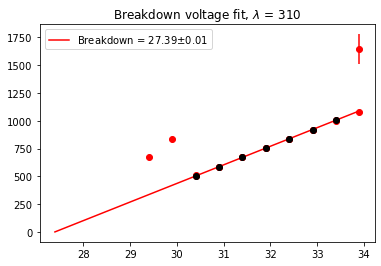

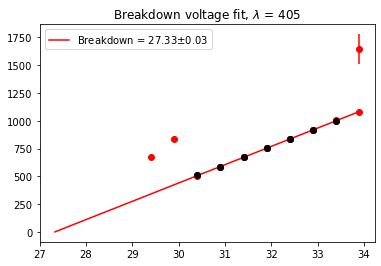

In [49]:
# change to have linear fit for both leds -- will need to use file_parts[-2][:-2] to separate them out -- will need to loop in block above

gain_vs_volts = np.array(gain_vs_volts[::-1])
wavelength = [310, 405]

voltages_to_exclude = [29.4, 29.9, 33.9]

for wl in wavelength:

    rows_to_skip = []
    for v in gain_vs_volts[:,0]:
        if(v in voltages_to_exclude):
            rows_to_skip.append(False)
        else:   
            rows_to_skip.append(True)
    rows_to_skip = np.array(rows_to_skip)
    
    rows_to_use = gain_vs_volts[:,3] == wl #select rows with the desired wavelength
    rows_to_use = rows_to_use & rows_to_skip
    bd_bp, bd_bc = curve_fit(lin_fun, gain_vs_volts[rows_to_use, 0], gain_vs_volts[rows_to_use, 1], sigma=gain_vs_volts[rows_to_use, 2])

    plt.figure()
    plt.errorbar(gain_vs_volts[:,0], gain_vs_volts[:,1], yerr=gain_vs_volts[:,2], fmt='ro')
    plt.errorbar(gain_vs_volts[rows_to_use,0], gain_vs_volts[rows_to_use,1], yerr=gain_vs_volts[rows_to_use,2], fmt='ko')
    #plt.errorbar(gain_vs_volts[~rows_to_use,0], gain_vs_volts[~rows_to_use,1], yerr=gain_vs_volts[~rows_to_use,2], fmt='ro')
    xx = np.linspace(bd_bp[1], np.max(gain_vs_volts[:,0]), 100)
    plt.plot(xx, lin_fun(xx,*bd_bp), 'r', label="Breakdown = %.2f$\pm$%.2f"%(bd_bp[1], np.sqrt(bd_bc[1,1])))
    plt.title("Breakdown voltage fit, $\lambda$ = %d"%wl)
    plt.legend()
    plt.show()

In [45]:
print(rows_to_use)

[False False False  True False  True False  True False  True False  True
 False  True False  True False False]


Found 4 files
Working on file #0: C:/Data/20230213/Step16\mca_keith_31.40OV_source_3.h5


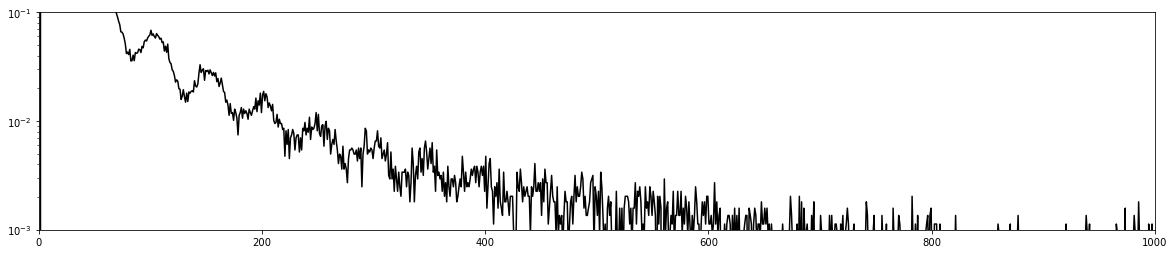

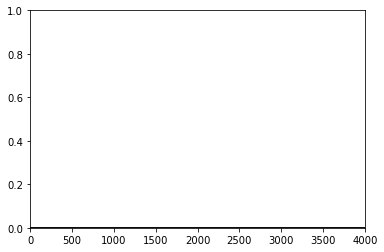

In [107]:
## Plot latest file

path = r"C:/Data/20230213/Step16/"

type_list = ['source']#, '405', '310']
col_list = ['k', 'b', 'purple']
nfiles = 1
norm_range = [3000, 12000] ## set range to normalize counts (leave empty to not use)

ref_hist = 0
fig1 = plt.figure(figsize=(20,4))
fig2 = plt.figure(figsize=(6,4))
for j,t in enumerate(type_list):
    file_list = natsort.realsorted(glob.glob(path + "*mca*%s*.h5"%t))
    print("Found %d files"%len(file_list))


    for i,file in enumerate(file_list[-nfiles:]): 
        print("Working on file #%d: %s"%(i,file))

        #file_parts = file.split("_")
        #file_volts = float( file_parts[-2][:-2] ) # get voltage from filename

        f = h5py.File(file, 'r')  
        ch2 = f.get('ch2')
        for key in ch2.keys():
            mca_hist = np.array(ch2.get(key))
        bin_num = np.arange(len(mca_hist))

        b, c = rebin_histogram(bin_num, mca_hist, 1)

        if(len(norm_range)==2):
            gpts = (b < norm_range[1]) & (b > norm_range[0])
            norm_fac = np.sum(c[gpts])
        else:
            norm_fac = 1

        if(t == "source"):
            ref_hist = c/norm_fac
        plt.figure(fig1.number)
        plt.semilogy(b, c/norm_fac, color=col_list[j])
        plt.ylim(1e-3,1e-1)
        plt.xlim(0,1000)

        plt.figure(fig2.number)
        plt.plot(b, c/norm_fac - ref_hist, color=col_list[j])
        plt.ylim(0,1)
        plt.xlim(0,4000)

plt.show()